In [374]:
%matplotlib inline
import numpy as np
import pandas as pd
from keras.models import load_model
from glob import glob
from keras import backend as K
import matplotlib.pyplot as plt
from os.path import join
from scipy.ndimage import gaussian_filter, maximum_filter, median_filter
from IPython.display import Image

In [400]:
out_path = "/scratch/dgagne/spatial_storm_results_20171220/"
sample = 2
model_name = "hail_conv_net_sample_{0:03d}.h5".format(sample)
hail_conv_net = load_model(join(out_path, model_name))

In [377]:
hail_conv_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12032     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 64)          0         
__________

In [10]:
hail_conv_net.layers[1].output

<tf.Tensor 'conv2d_1/BiasAdd:0' shape=(?, 16, 16, 32) dtype=float32>

In [476]:
hail_conv_net.layers[-7].get_weights()[0].argmax()

143983

(array([  15.,   80.,  272.,  345.,  369.,  335.,  333.,  210.,   75.,   14.]),
 array([-0.05220393, -0.0412923 , -0.03038068, -0.01946905, -0.00855742,
         0.0023542 ,  0.01326583,  0.02417746,  0.03508909,  0.04600071,
         0.05691234]),
 <a list of 10 Patch objects>)

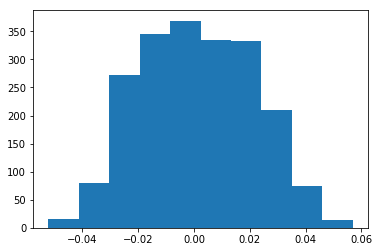

In [483]:
plt.hist(hail_conv_net.layers[-2].get_weights()[0][:, 0])

In [452]:
hail_conv_net.layers[-7]

In [442]:
hail_conv_net.layers[-7].get_weights()[0].shape

(5, 5, 64, 128)

In [444]:
np.unravel_index(1927,(1,4,4,128))

(0, 3, 3, 7)

In [527]:
def visualize_layer(cnn_model, layer_num, fil_idx, num_iter=20):
    layer_out = cnn_model.layers[layer_num].output
    input_image = cnn_model.layers[0].input
    loss = 1 - layer_out
    grads = K.gradients(loss, input_image)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_image, K.learning_phase()], 
                         [loss, grads])
    input_img_data = np.zeros((1, 32, 32, 15))
    #input_img_data = np.random.normal(size=(1, 32, 32, 15)) * 0.1
    step = 0.01
    for i in range(25):
        loss_value, grads_value = iterate([input_img_data, False])
        input_img_data -= grads_value * step
    return input_img_data

In [525]:
layer_vis = visualize_layer(hail_conv_net, -1, 1)

[[ 0.99772078]]
[[ 0.99723798]]
[[ 0.99563539]]
[[ 0.99182612]]
[[ 0.97935414]]
[[ 0.92803401]]
[[ 0.74083745]]
[[ 0.39554644]]
[[ 0.13343298]]
[[ 0.03414977]]
[[ 0.00974226]]
[[ 0.00330317]]
[[ 0.00139421]]
[[ 0.00075352]]
[[ 0.00048149]]
[[ 0.00034392]]
[[ 0.00026304]]
[[ 0.00021082]]
[[ 0.0001753]]
[[ 0.00014997]]
[[ 0.00013125]]
[[ 0.00011694]]
[[ 0.00010538]]
[[  9.59634781e-05]]
[[  8.80956650e-05]]


1.09659437183
0.90697037708
1.60020107217
0.523591341247
0.543791545322
1.00694659119
0.469063482247
0.535517645301
1.05080015538
0.459704433662
0.9244937927
0.615736903943
0.535709128249
0.441841139924
0.627740852535


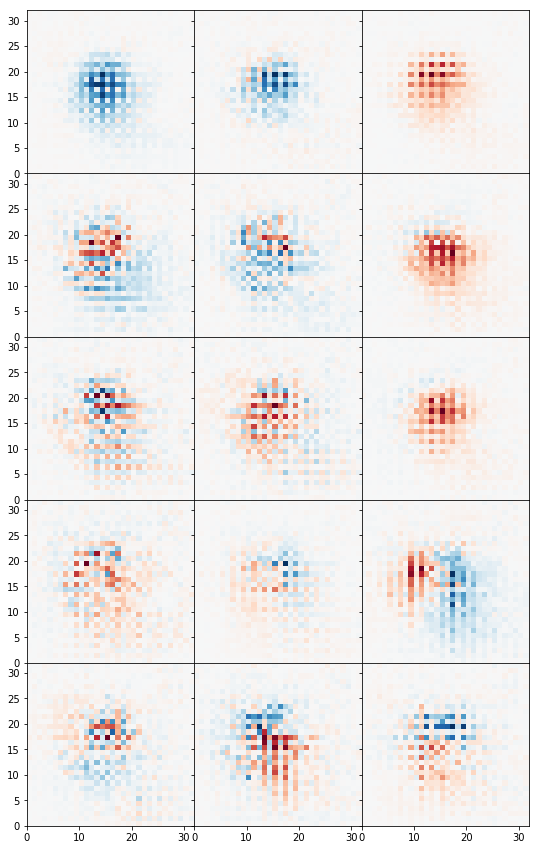

In [522]:
fig, axes = plt.subplots(5, 3, figsize=(9, 15), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
axef = axes.ravel()
for a, ax in enumerate(axef):
    v_max = np.abs(layer_vis[0, :, :, a]).max()
    print(v_max)
    ax.pcolormesh(gaussian_filter(layer_vis[0, :, :, a],0), vmin=-v_max, vmax=v_max, cmap="RdBu_r")

-0.370633798651
-0.41898360895
-0.38901414827


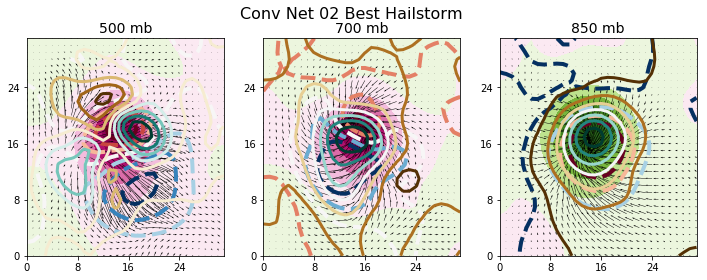

In [523]:
fig = plt.figure(figsize=(12, 4))
heights = [500, 700, 850]
for a in np.arange(3):
    plt.subplot(1,3, a + 1)
    hght_g = gaussian_filter(layer_vis[0, :, :, a], 2)
    hght = plt.contourf(hght_g / hght_g.std(), np.linspace(-4, 4, 9), extend="both", cmap="PiYG")
    print(gaussian_filter(layer_vis[0, :, :, 3 + a], 0).min())
    tmpc_g = gaussian_filter(layer_vis[0, :, :, 3 + a], 2)
    tmpc = plt.contour(tmpc_g / tmpc_g.std(), 
                       [-3, -2, -1, 0, 1, 2, 3], linewidths=4, linestyles="--", cmap="RdBu_r")
    dewp_g = gaussian_filter(layer_vis[0, :, :, 6 + a], 2)
    dewp = plt.contour(dewp_g / dewp_g.std(), 7, linewidths=3, cmap="BrBG")
    u_g = gaussian_filter(layer_vis[0, :, :, 9 + a], 2)
    v_g = gaussian_filter(layer_vis[0, :, :, 12 + a], 2)
    plt.quiver(np.arange(32), np.arange(32), u_g / u_g.std(),
              v_g / v_g.std(), scale_units="width", scale=30, color="k")
    plt.xticks(np.arange(0, 32, 8))
    plt.yticks(np.arange(0, 32, 8))
    plt.title("{0:d} mb".format(heights[a]), fontsize=14)
plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(sample), fontsize=16, y=0.99)
plt.savefig("/scratch/dgagne/spatial_hail_interp/best_hailstorm_{0:03d}.png".format(sample), bbox_inches="tight",
            dpi=300)

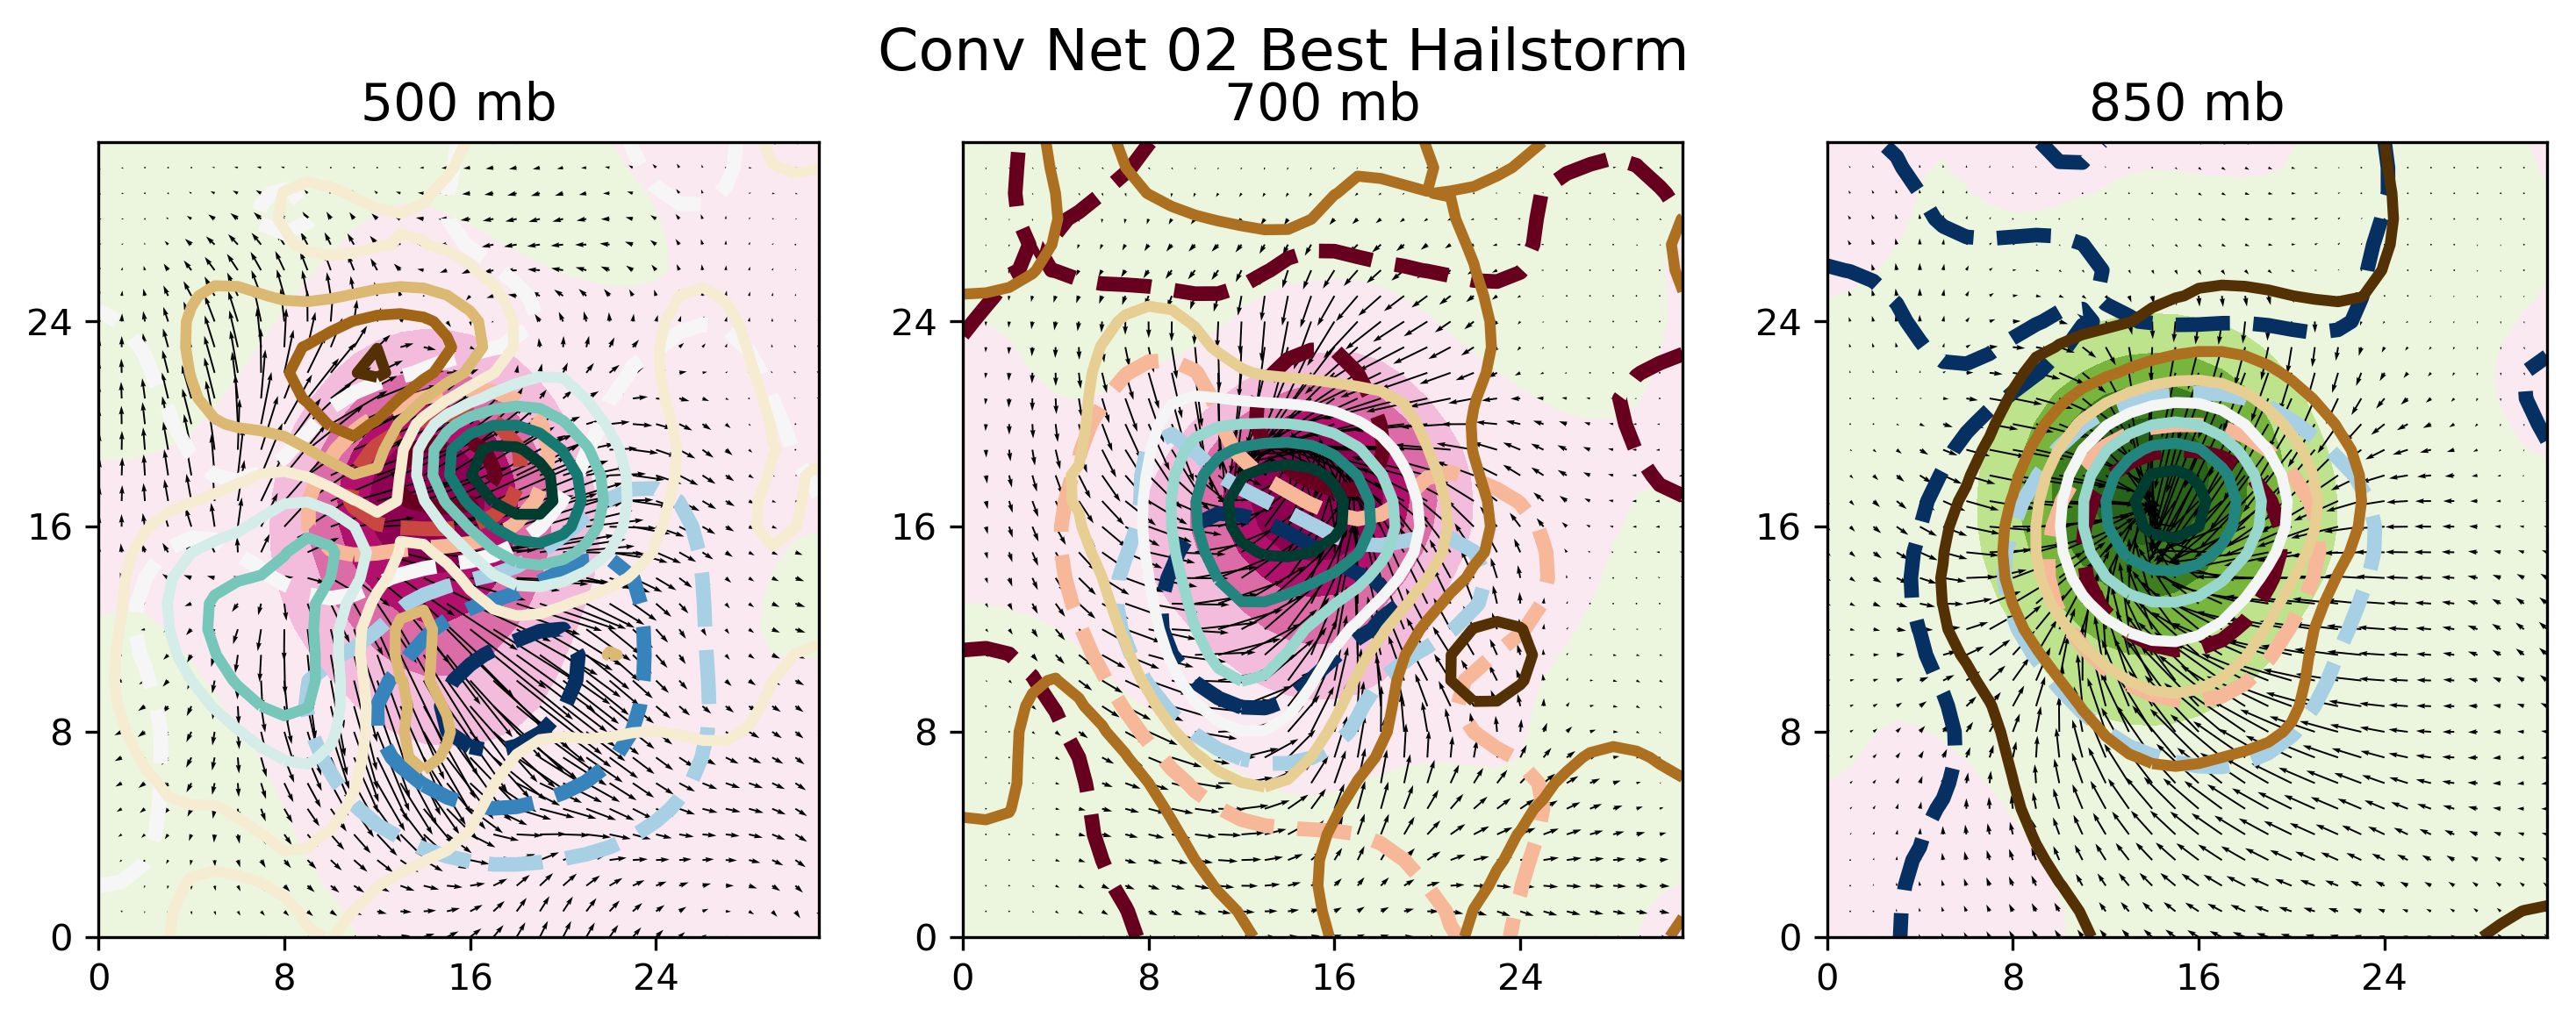

In [518]:
Image("/scratch/dgagne/spatial_hail_interp/best_hailstorm_002.png")

In [528]:
def plot_best_hailstorm(layer_vis, sample):
    fig = plt.figure(figsize=(12, 4))
    heights = [500, 700, 850]
    for a in np.arange(3):
        plt.subplot(1,3, a + 1)
        hght_g = gaussian_filter(layer_vis[0, :, :, a], 2)
        hght = plt.contourf(hght_g / hght_g.std(), np.linspace(-4, 4, 9), extend="both", cmap="PiYG")
        print(gaussian_filter(layer_vis[0, :, :, 3 + a], 0).min())
        tmpc_g = gaussian_filter(layer_vis[0, :, :, 3 + a], 2)
        tmpc = plt.contour(tmpc_g / tmpc_g.std(), 
                           [-3, -2, -1, 0, 1, 2, 3], linewidths=4, linestyles="--", cmap="RdBu_r")
        dewp_g = gaussian_filter(layer_vis[0, :, :, 6 + a], 2)
        dewp = plt.contour(dewp_g / dewp_g.std(), 7, linewidths=3, cmap="BrBG")
        u_g = gaussian_filter(layer_vis[0, :, :, 9 + a], 2)
        v_g = gaussian_filter(layer_vis[0, :, :, 12 + a], 2)
        plt.quiver(np.arange(32), np.arange(32), u_g / u_g.std(),
                  v_g / v_g.std(), scale_units="width", scale=30, color="k")
        plt.xticks(np.arange(0, 32, 8))
        plt.yticks(np.arange(0, 32, 8))
        plt.title("{0:d} mb".format(heights[a]), fontsize=14)
    plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(sample), fontsize=16, y=0.99)
    plt.savefig("/scratch/dgagne/spatial_hail_interp/best_hailstorm_{0:03d}.png".format(sample), bbox_inches="tight",
                dpi=300)
    plt.close()

In [529]:
for sample in range(30):
    print(sample)
    model_name = "hail_conv_net_sample_{0:03d}.h5".format(sample)
    hail_conv_net = load_model(join(out_path, model_name))
    layer_vis = visualize_layer(hail_conv_net, -1, 0)
    plot_best_hailstorm(layer_vis, sample)

0
-0.252505490498
-0.515058722813
-0.572498821391
1
-0.412133814913
-0.383844539114
-0.291013504146
2
-0.370633798535
-0.418983609881
-0.389014133369
3
-0.239154197858
-0.462513564038
-0.0957683282904
4
-0.696519210527
-0.733412845177
-0.822846192401
5
-0.45934072102
-0.494044232881
-0.256898920401
6
-0.949176299386
-1.20459417114
-0.385531154228
7
-0.785731120501
-0.547644977865
-0.181755518497
8
-0.790677953511
-0.898561763821
-0.351365356357
9
-0.335963324644
-0.687542862957
-0.289325921563
10
-0.220582191832
-0.41134217917
-0.214649257832
11
-0.396061858275
-0.755991322687
-0.0788891750781
12
-0.925580212381
-0.899756158731
-0.562091423315
13
-0.341068066424
-0.418252102099
-0.258209578111
14
-0.453845022479
-1.03829588398
-0.143436473154
15
-0.356552859332
-0.5096903909
-0.173477567732
16
-0.452069051866
-0.440144086257
-0.267043714237
17
-1.11731651495
-0.142130767308
-0.390869409195
18
-0.49272743825
-0.735296592349
-0.3105064517
19
-1.30652033538
-0.427719312254
-0.242574206612

-0.029305365731872545

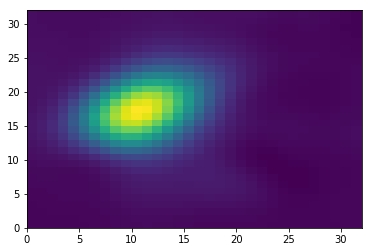

In [325]:
plt.pcolormesh(hght_g)
hght_g.min()

In [75]:
weights = hail_conv_net.layers[1].get_weights()[0]

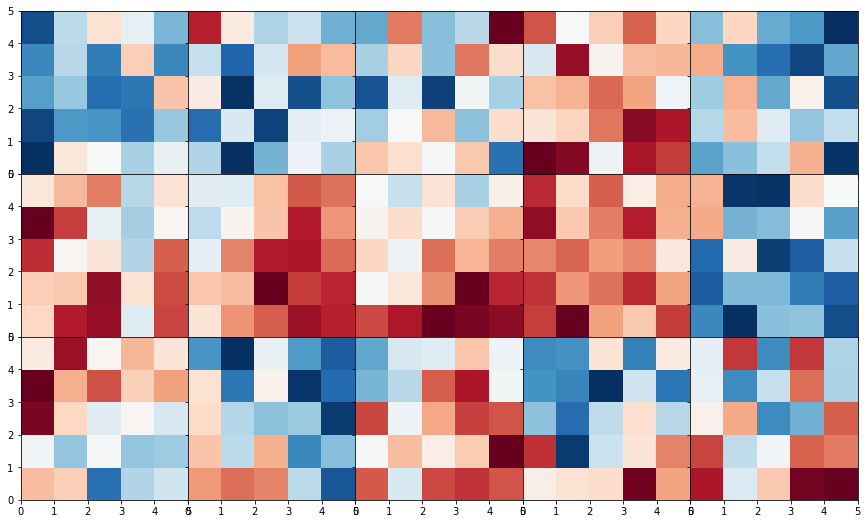

In [84]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
axef = axes.ravel()
filter_val = 0
for a, ax in enumerate(axef):
    v_max = np.abs(weights[:, :, a, filter_val]).max()
    ax.pcolormesh(weights[:, :, a, filter_val], vmin=-v_max, vmax=v_max, cmap="RdBu_r")

In [78]:
weights.max()

0.036789883

In [394]:
best_configs = pd.read_csv("/scratch/dgagne/spatial_storm_results_20171220/conv_net_best_params.csv", index_col="Sample")

In [395]:
best_configs

,index,activation,batch_size,data_width,dropout_alpha,filter_growth_rate,filter_width,learning_rate,loss,metrics,min_conv_filters,min_data_width,num_epochs,num_gpus,num_input_channels,optimizer,regularization_alpha
Sample,,,,,,,,,,,,,,,,,
0,62,relu,128,32,0.3,2,5,0.0001,mse,['mae'],32,4,15,8,15,adam,0.010
1,63,relu,128,32,0.3,2,5,0.0001,mse,['mae'],32,4,15,8,15,adam,0.001
2,63,relu,128,32,0.3,2,5,0.0001,mse,['mae'],32,4,15,8,15,adam,0.001
3,30,leaky,128,32,0.3,2,5,0.0001,mse,['mae'],32,4,15,8,15,adam,0.010
4,58,relu,128,32,0.3,2,5,0.0001,mse,['mae'],16,4,15,8,15,adam,0.010
5,63,relu,128,32,0.3,2,5,0.0001,mse,['mae'],32,4,15,8,15,adam,0.001
6,46,relu,128,32,0.1,2,5,0.0001,mse,['mae'],32,4,15,8,15,adam,0.010
7,62,relu,128,32,0.3,2,5,0.0001,mse,['mae'],32,4,15,8,15,adam,0.010
8,62,relu,128,32,0.3,2,5,0.0001,mse,['mae'],32,4,15,8,15,adam,0.010


In [545]:
conv_sample_scores = pd.read_csv("/scratch/dgagne/spatial_storm_results_20171220/conv_net_sample_scores.csv", index_col="Sample")
logistic_pca_sample_scores = pd.read_csv("/scratch/dgagne/spatial_storm_results_20171220/logistic_pca_sample_scores.csv", index_col="Sample")

In [540]:
def bootstrap(values, n_boot=1000):
    boot_scores = np.zeros(n_boot)
    for b in range(n_boot):
        boot_vals = np.random.choice(values, size=values.size, replace=True)
        boot_scores[b] = boot_vals.mean()
    return boot_scores

In [546]:
conv_net_boot_auc = bootstrap(conv_sample_scores["AUC"].values)
logistic_pca_boot_auc = bootstrap(logistic_pca_sample_scores["AUC"].values)

In [547]:
np.percentile(conv_net_boot_auc, [1, 2.5, 5, 50, 95, 97.5, 99])

array([ 0.88254286,  0.88341001,  0.88414532,  0.88758912,  0.89097981,
        0.89163403,  0.89225845])

In [548]:
np.percentile(logistic_pca_boot_auc, [1, 2.5, 5, 50, 95, 97.5, 99])

array([ 0.84881464,  0.85004458,  0.85093743,  0.85587871,  0.86044694,
        0.86113192,  0.86257399])

In [549]:
conv_net_boot_bss = bootstrap(conv_sample_scores["Brier Skill Score"].values)
logistic_pca_boot_bss = bootstrap(logistic_pca_sample_scores["Brier Skill Score"].values)

In [550]:
np.percentile(conv_net_boot_bss, [1, 2.5, 5, 50, 95, 97.5, 99])

array([ 0.3633078 ,  0.36528531,  0.36701097,  0.37552957,  0.38346286,
        0.38452086,  0.3866319 ])

In [552]:
np.percentile(logistic_pca_boot_bss, [1, 2.5, 5, 50, 95, 97.5, 99, 99.9])

array([ 0.29280831,  0.29422272,  0.29571756,  0.30437548,  0.31241507,
        0.3137975 ,  0.31478265,  0.31842529])

In [553]:
conv_sample_scores

,Brier Score,Brier Score Climo,Brier Skill Score,AUC
Sample,,,,
0,0.085811,0.141335,0.392856,0.896425
1,0.092550,0.148723,0.377699,0.896318
2,0.082178,0.134000,0.386731,0.885710
3,0.101475,0.160750,0.368743,0.872207
4,0.089099,0.146835,0.393201,0.890249
5,0.085663,0.139273,0.384927,0.898119
6,0.095748,0.149644,0.360162,0.879635
7,0.091436,0.147494,0.380070,0.879603
8,0.094411,0.148059,0.362343,0.885974
